In [123]:
# For general data processing
import numpy as np
import pandas as pd
import math

# Custom functions for measuring time of queries and to print lists
from notebook_functions.timer import timer_wrapper
from notebook_functions.print import print_list

# For static plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# For the engine that connects Python and MySQL
import sqlalchemy

# For interactive plotting
import plotly.express as px
import plotly.graph_objects as go

In [9]:
# Timer wrapper calculates the time used by below function everytime it is run
@timer_wrapper
def pandas_read_sql(engine, sql_stmt):
    """
    =======
    PURPOSE
    =======
    Send a SQL query to a SQL database using a created SQLAlchemy engine, thens receives the output from the SQL DBMS into a pandas DataFrame.
    
    ======
    INPUTS
    ======
    engine: a SQLAlchemy engine object created using the sqlalchemy.create_engine() method.
    sql_stmt: a string containing the SQL statement to be fed to the SQL DBMS through the engine.
    
    =======
    OUTPUTS
    =======
    df: a pandas DataFrame containing the output from the SQL DBMS after it has processed the sent SQL query.
    
    =======
    EXAMPLE
    =======

    sql_stmt = '''SELECT * FROM table'''
    
    sql_df = pandas_read_sql(engine, sql_stmt)

    >>> sql_df
    """

    assert isinstance(sql_stmt, str), "Passed object is not a string"

    # Open a connection to the SQL DBMS using the engine
    with engine.connect() as conn:
        
        # Convert string into a SQLAlchemy SQL statement
        stmt = sqlalchemy.text(f"""{sql_stmt}""")

        # Send the SQL statement to the SQL DBMS and receive the output using
        df = pd.read_sql(
            stmt,
            con = conn)
        
    return df

In [10]:
# SQL Statement to count the number of rides aggregated by the start date of each ride in UTC timezone.
sql_stmt = """
WITH a AS (
SELECT
    DATE_FORMAT(CONVERT_TZ(start_dt_utc,"+00:00","-04:00"), "%Y-%m-%d") AS yyyymmdd,
    COUNT(*) AS rides,
    is_member,
    start_stn_code,
    data_source
FROM
    rides
WHERE
    YEAR(start_dt_utc) < 2022
GROUP BY
    yyyymmdd,
    is_member,
    start_stn_code,
    data_source
)

SELECT
    a.yyyymmdd,
    a.rides,
    a.is_member,
    a.start_stn_code,
    c.stn_lat,
    c.stn_lon,
    c.stn_name
FROM
    a
LEFT JOIN
    jt_rides_stations AS b
ON
    a.data_source = b.ride_files
LEFT JOIN
    stations AS c
ON
    b.station_files = c.data_source
    AND a.start_stn_code = c.stn_code
ORDER BY
    a.yyyymmdd ASC
"""

df = pandas_read_sql(engine,sql_stmt)

Run 1 of pandas_read_sql took 451.3584 seconds.
Total run time: 451.3584 seconds. Average run time: 451.3584 seconds. 



In [11]:
df.shape

(1653511, 7)

In [12]:
df.head()

,yyyymmdd,rides,is_member,start_stn_code,stn_lat,stn_lon,stn_name
0,2014-04-15,3,0,6099,45.497411,-73.578271,Bishop / de Maisonneuve
1,2014-04-15,1,0,6138,45.531818,-73.565317,Gauthier / De Lorimier
2,2014-04-15,2,0,6142,45.527791,-73.572056,Calixa-Lavallée / Rachel
3,2014-04-15,1,0,6181,45.517354,-73.582129,Clark / Rachel
4,2014-04-15,1,0,6191,45.531401,-73.612674,St-Zotique / Clark


In [13]:
df.to_csv("analysis_data/20230824.csv", index = False)

# Plot 1 Riders by Year

In [33]:
plot_df = df.groupby(
    by = "yyyymmdd",
    as_index = False).agg(
        rides = ("rides","sum")
)

# Convert yyyymmdd column to datetime
plot_df["yyyymmdd"] = plot_df["yyyymmdd"].astype("datetime64[ns]")

# Use yyyymmdd as index
plot_df.set_index(["yyyymmdd"], inplace = True)

In [34]:
plot_df.head()

,rides
yyyymmdd,
2014-04-15,1577
2014-04-16,3180
2014-04-17,5852
2014-04-18,5325
2014-04-19,6031


In [37]:
plot_df = plot_df.resample("1YS").sum()
plot_df['year'] = plot_df.index.year
plot_df

,rides,year
yyyymmdd,,
2014-01-01,3136276,2014
2015-01-01,3443883,2015
2016-01-01,4000080,2016
2017-01-01,4740357,2017
2018-01-01,5277541,2018
2019-01-01,5597845,2019
2020-01-01,3264741,2020
2021-01-01,5566351,2021


In [58]:
plot_df['rides'] = plot_df['rides']/1_000_000

In [ ]:
plot_df["YoY_pct_plot"] = np.where(plot_df["year"] <= 2019, plot_df["YoY_pct_plot"], np.NaN)

In [59]:
plot_df

,rides,year
yyyymmdd,,
2014-01-01,3.136276,2014
2015-01-01,3.443883,2015
2016-01-01,4.000080,2016
2017-01-01,4.740357,2017
2018-01-01,5.277541,2018
2019-01-01,5.597845,2019
2020-01-01,3.264741,2020
2021-01-01,5.566351,2021


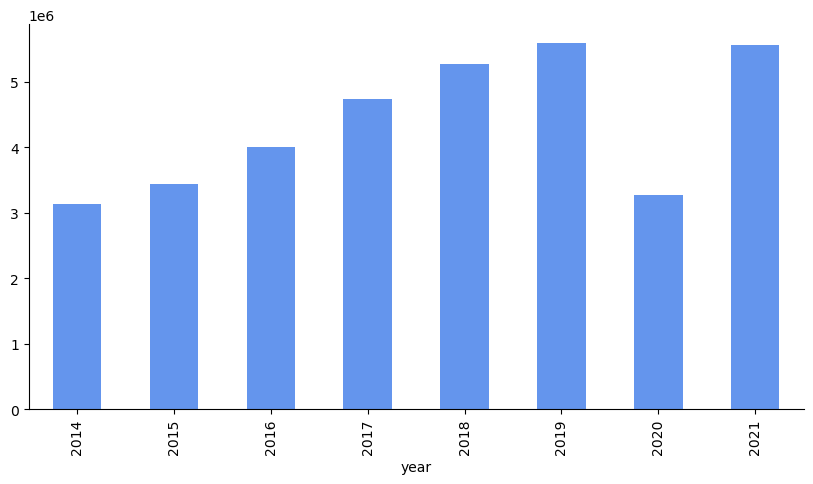

In [39]:
fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (10,5)
)

plot_df.plot(
    x = "year",
    y = "rides",
    ax = ax,
    legend = None,
    color = "cornflowerblue",
    kind = "bar"
)

sns.despine()

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


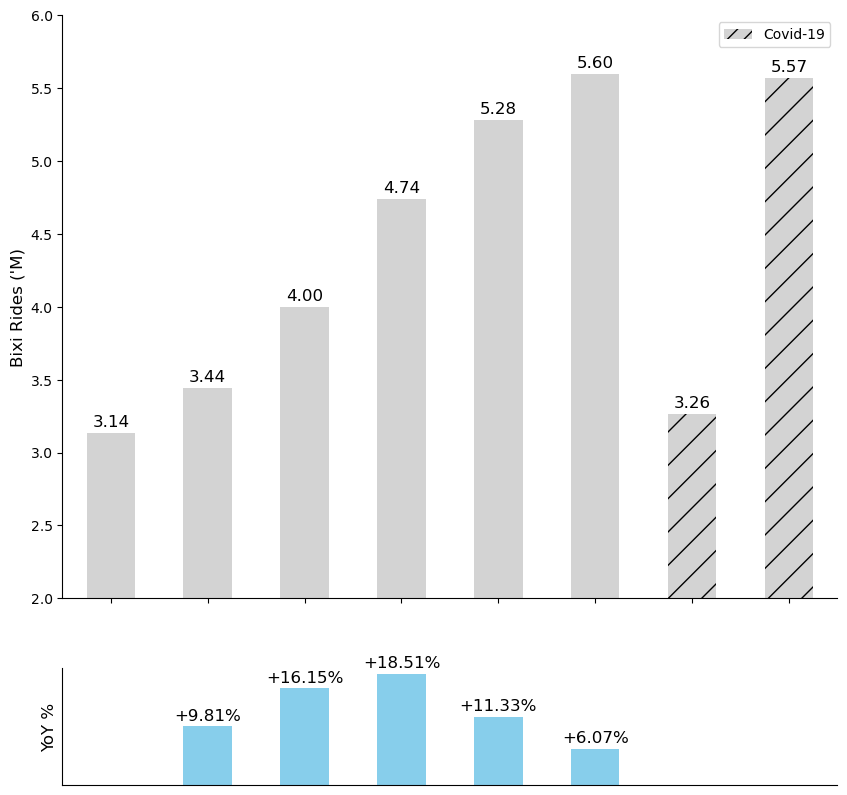

In [196]:
fig, ax = plt.subplots(
    nrows = 2,
    ncols = 1,
    figsize = (10,10),
    height_ratios = [5,1],
    sharex = True
)

covid_years = [2020,2021]

hatch = ["/" if year in covid_years else "" for year in plot_df["year"]]

plot_df.plot(
    x = "year",
    y = "rides",
    ax = ax[0],
    color = "lightgrey",
    kind = "bar",
    hatch = hatch
)

for label in ax[0].get_xticklabels():
    label.set_rotation(0)

vertical_offset = plot_df['rides'].mean() * 0.01

for xtick in ax[0].get_xticks():
    ax[0].text(
        x = xtick,
        y = plot_df["rides"][xtick] + vertical_offset,
        s = "{:.2f}".format(round(plot_df["rides"][xtick],2)),
        horizontalalignment = 'center',
        size = "large",
        color = "black"
    )
        
ax[0].set_xlabel(f"Year", size = 12)
ax[0].set_ylabel(f"Bixi Rides ('M)", size = 12)
ax[0].set_ylim(2,6)

legend_elements = [Patch(facecolor = "lightgrey", hatch = "//", label = "Covid-19")]
ax[0].legend(handles = legend_elements)    



# Plotting YoY% change
colors = ["skyblue" if x >= 0 else "slateblue" for x in plot_df["YoY_pct_plot"]]

plot_df.plot(
    x = "year",
    y = "YoY_pct_plot",
    ax = ax[1],
    kind = "bar",
    legend = None,
    color = colors
)

vertical_offset = 0.01

for xtick in ax[1].get_xticks():
    if plot_df["YoY_pct_plot"][xtick] >= 0:
        ax[1].text(
            x = xtick,
            y = plot_df["YoY_pct_plot"][xtick] + vertical_offset,
            s = "{:+.2%}".format(round(plot_df["YoY_pct_plot"][xtick],4)),
            horizontalalignment = 'center',
            size = "large",
            color = "black"
        )
    else:
        ax[1].text(
            x = xtick,
            y = plot_df["YoY_pct_plot"][xtick] - vertical_offset * 8,
            s = "{:+.2%}".format(round(plot_df["YoY_pct_plot"][xtick],4)),
            horizontalalignment = 'center',
            size = "large",
            color = "black"
        )

ax[1].spines["bottom"].set_position("zero")
ax[1].tick_params(
    # axis = "x",
    # which = "both",
    left = False,
    bottom = False,
    top = False,
    labelbottom = False,
    labelleft = False)

ax[1].set_xlabel(f"")
ax[1].set_ylabel(f"YoY %", size = 12)

sns.despine()
plt.show()

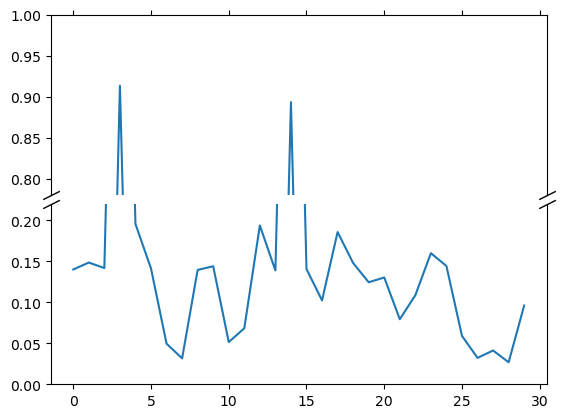

In [183]:
plot_df

,rides,year,LY_rides,YoY_pct,YoY_pct_plot
yyyymmdd,,,,,
2014-01-01,3.136276,2014,NaN,NaN,NaN
2015-01-01,3.443883,2015,3.136276,0.098080,0.098080
2016-01-01,4.000080,2016,3.443883,0.161503,0.161503
2017-01-01,4.740357,2017,4.000080,0.185066,0.185066
2018-01-01,5.277541,2018,4.740357,0.113321,0.113321
2019-01-01,5.597845,2019,5.277541,0.060692,0.060692
2020-01-01,3.264741,2020,5.597845,-0.416786,NaN
2021-01-01,5.566351,2021,3.264741,0.704990,NaN


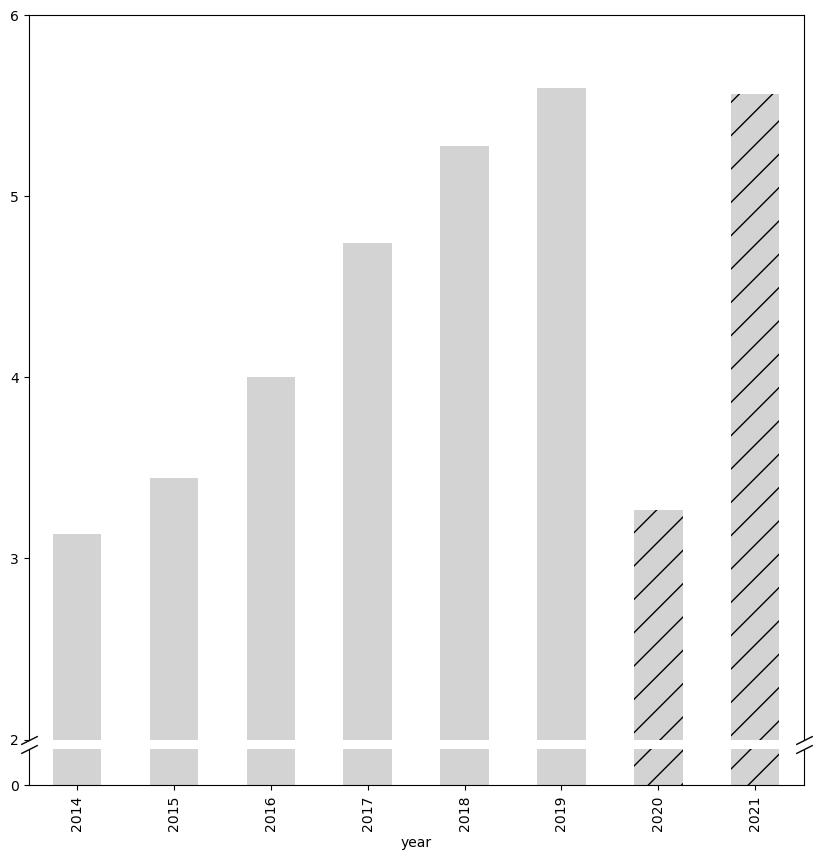

In [224]:
fig, ax = plt.subplots(
    nrows = 2,
    ncols = 1,
    figsize = (10,10),
    height_ratios = [20,1],
    sharex = True
)

covid_years = [2020,2021]

hatch = ["/" if year in covid_years else "" for year in plot_df["year"]]

plot_df.plot(
    x = "year",
    y = "rides",
    ax = ax[0],
    color = "lightgrey",
    kind = "bar",
    hatch = hatch,
    legend = None
)

plot_df.plot(
    x = "year",
    y = "rides",
    ax = ax[1],
    color = "lightgrey",
    kind = "bar",
    hatch = hatch,
    legend = None
)

ax[0].set_ylim(2,6)
ax[1].set_ylim(0,0.1)

# hide the spines between ax and ax2
ax[0].tick_params(
    bottom = False,
    top = False,
    labelbottom = False)

ax[0].set_yticks(np.arange(2,7, step = 1))

# Remove spines between top and bottom
ax[0].spines.bottom.set_visible(False)
ax[1].spines.top.set_visible(False)

ax[1].set_yticks(np.arange(0,2, step = 2))

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

plt.subplots_adjust(hspace = 0.025)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


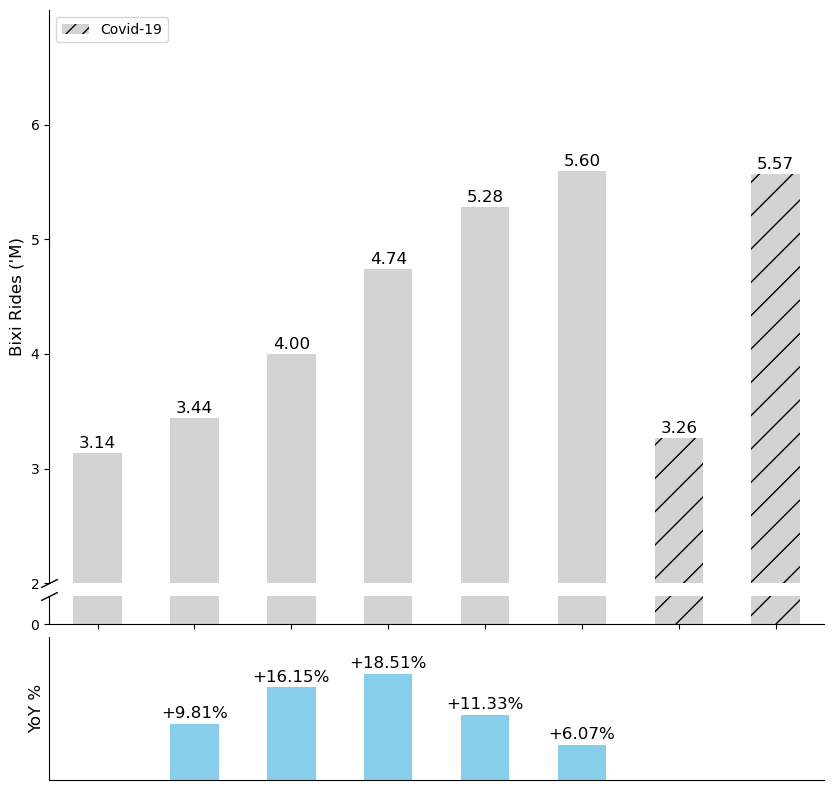

In [260]:
fig, ax = plt.subplots(
    nrows = 3,
    ncols = 1,
    figsize = (10,10),
    height_ratios = [20,1,5],
    sharex = True
)

covid_years = [2020,2021]

hatch = ["/" if year in covid_years else "" for year in plot_df["year"]]

plot_df.plot(
    x = "year",
    y = "rides",
    ax = ax[0],
    color = "lightgrey",
    kind = "bar",
    hatch = hatch,
    legend = None
)

plot_df.plot(
    x = "year",
    y = "rides",
    ax = ax[1],
    color = "lightgrey",
    kind = "bar",
    hatch = hatch,
    legend = None
)

ax[0].set_ylim(2,7)
ax[1].set_ylim(0,0.1)

# hide the spines between ax and ax2
ax[0].tick_params(
    bottom = False,
    top = False,
    labelbottom = False)

ax[0].set_yticks(np.arange(2,7, step = 1))

ax[1].set_yticks(np.arange(0,2, step = 2))

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0], [0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0], [1], transform=ax[1].transAxes, **kwargs)

for label in ax[1].get_xticklabels():
    label.set_rotation(0)

vertical_offset = plot_df['rides'].mean() * 0.01

for xtick in ax[0].get_xticks():
    ax[0].text(
        x = xtick,
        y = plot_df["rides"][xtick] + vertical_offset,
        s = "{:.2f}".format(round(plot_df["rides"][xtick],2)),
        horizontalalignment = 'center',
        size = "large",
        color = "black"
    )
        
ax[1].set_xlabel(f"Year", size = 12)
ax[0].set_ylabel(f"Bixi Rides ('M)", size = 12)

legend_elements = [Patch(facecolor = "lightgrey", hatch = "//", label = "Covid-19")]
ax[0].legend(handles = legend_elements, loc = "upper left")    

#####

# Plotting YoY% change
colors = ["skyblue" if x >= 0 else "slateblue" for x in plot_df["YoY_pct_plot"]]

plot_df.plot(
    x = "year",
    y = "YoY_pct_plot",
    ax = ax[2],
    kind = "bar",
    legend = None,
    color = colors
)

vertical_offset = 0.01

for xtick in ax[2].get_xticks():
    if plot_df["YoY_pct_plot"][xtick] >= 0:
        ax[2].text(
            x = xtick,
            y = plot_df["YoY_pct_plot"][xtick] + vertical_offset,
            s = "{:+.2%}".format(round(plot_df["YoY_pct_plot"][xtick],4)),
            horizontalalignment = 'center',
            size = "large",
            color = "black"
        )
    else:
        ax[2].text(
            x = xtick,
            y = plot_df["YoY_pct_plot"][xtick] - vertical_offset * 8,
            s = "{:+.2%}".format(round(plot_df["YoY_pct_plot"][xtick],4)),
            horizontalalignment = 'center',
            size = "large",
            color = "black"
        )

ax[2].spines["bottom"].set_position("zero")
ax[2].tick_params(
    left = False,
    bottom = False,
    top = False,
    labelbottom = False,
    labelleft = False)

ax[2].set_xlabel(f"")
ax[2].set_ylabel(f"YoY %", size = 12)
ax[2].set_ylim(0,0.25)

sns.despine()
# Remove spines between top and bottom
ax[0].spines.top.set_visible(False)
ax[0].spines.bottom.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[0].spines.right.set_visible(False)
ax[1].spines.right.set_visible(False)

fig.subplots_adjust(hspace=0.05)  # adjust space between axes

plt.show()